In [1]:
load_google_drive_data <- function(google_file_url){
    g_link = google_file_url 
    file_id = substr(g_link, regexpr("/d/", g_link) + 3 ,  regexpr("/view", g_link) -1 )
    url =  paste("https://drive.google.com/uc?export=download&id=", file_id, sep="")
    download.file(url, "file.csv")
    df <- read.csv("file.csv" , stringsAsFactors = TRUE)
    return(df)
}

In [ ]:
install.packages("stringr")
install.packages("car")
install.packages("ggplot2")
install.packages("corrplot")
install.packages("xlsx")
install.packages("reshape2")
install.packages("reshape")
install.packages('ISLR')
install.packages("readr")
install.packages('caret')
install.packages('caTools')
install.packages('rpart.plot')
install.packages('rpart')
install.packages("party")
install.packages("partykit")
install.packages("package:stats")
install.packages('vcd')
install.packages('mltools')

In [ ]:
library(dplyr)
library(ggplot2)
library(MASS) 
library(reshape2) 
library(reshape) 
library(corrplot)
library(scales)
library(plyr)
library(caTools)
library(rpart)
library(rpart.plot)
library(tidyverse) #perform data manipulation & visualization 
library(caret) # cross - validation methods, provides findCorrelation function
library(ISLR)# import desired dataset
library(readr)
library(party)
library(partykit)
library(stringr)
library(car)
require(xgboost)
require(Matrix)
require(data.table)

# **1- Part 1 (Classification)**


## **1 - Ensure data is in the correct format for downstream processes and address missing data (5 points)**


In [153]:
churn_data <- load_google_drive_data("https://drive.google.com/file/d/1oxpUud5p9infkOfnVSR7sqpuoHrfZEDa/view?usp=sharing" )
head(churn_data)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,⋯,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
1,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,⋯,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
2,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,⋯,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,⋯,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
4,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,⋯,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
5,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,⋯,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
6,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,⋯,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes


In [154]:
str(churn_data)

'data.frame':	7043 obs. of  21 variables:
 $ customerID      : Factor w/ 7043 levels "0002-ORFBO","0003-MKNFE",..: 5376 3963 2565 5536 6512 6552 1003 4771 5605 4535 ...
 $ gender          : Factor w/ 2 levels "Female","Male": 1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Partner         : Factor w/ 2 levels "No","Yes": 2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents      : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 2 ...
 $ tenure          : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService    : Factor w/ 2 levels "No","Yes": 1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines   : Factor w/ 3 levels "No","No phone service",..: 2 1 1 2 1 3 3 2 3 1 ...
 $ InternetService : Factor w/ 3 levels "DSL","Fiber optic",..: 1 1 1 1 2 2 2 1 2 1 ...
 $ OnlineSecurity  : Factor w/ 3 levels "No","No internet service",..: 1 3 3 3 1 1 1 3 1 3 ...
 $ OnlineBackup    : Factor w/ 3 levels "No","No internet service",..: 3 1 3 1 1 1 3 1 1 3 ...
 $ DeviceProtection: Factor w/ 3 levels "No","

In [155]:
summary(churn_data)


      customerID      gender     SeniorCitizen    Partner    Dependents
 0002-ORFBO:   1   Female:3488   Min.   :0.0000   No :3641   No :4933  
 0003-MKNFE:   1   Male  :3555   1st Qu.:0.0000   Yes:3402   Yes:2110  
 0004-TLHLJ:   1                 Median :0.0000                        
 0011-IGKFF:   1                 Mean   :0.1621                        
 0013-EXCHZ:   1                 3rd Qu.:0.0000                        
 0013-MHZWF:   1                 Max.   :1.0000                        
 (Other)   :7037                                                       
     tenure      PhoneService          MultipleLines     InternetService
 Min.   : 0.00   No : 682     No              :3390   DSL        :2421  
 1st Qu.: 9.00   Yes:6361     No phone service: 682   Fiber optic:3096  
 Median :29.00                Yes             :2971   No         :1526  
 Mean   :32.37                                                          
 3rd Qu.:55.00                                             

In [156]:
ch_data<- na.omit(churn_data)
Churn_ <- data.frame(ch_data)
churn_ <- subset(Churn_ , select = - customerID)

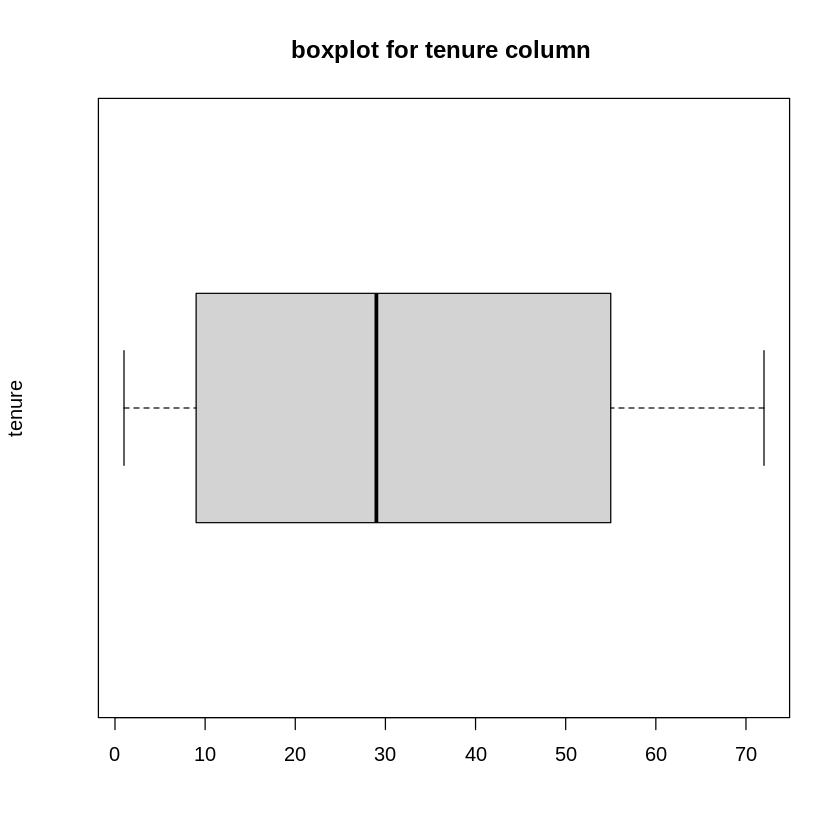

In [157]:
# checking for the outliers 
boxplot(churn_$tenure,
        main = 'boxplot for tenure column ', 
        ylab = 'tenure',
        horizontal = TRUE )

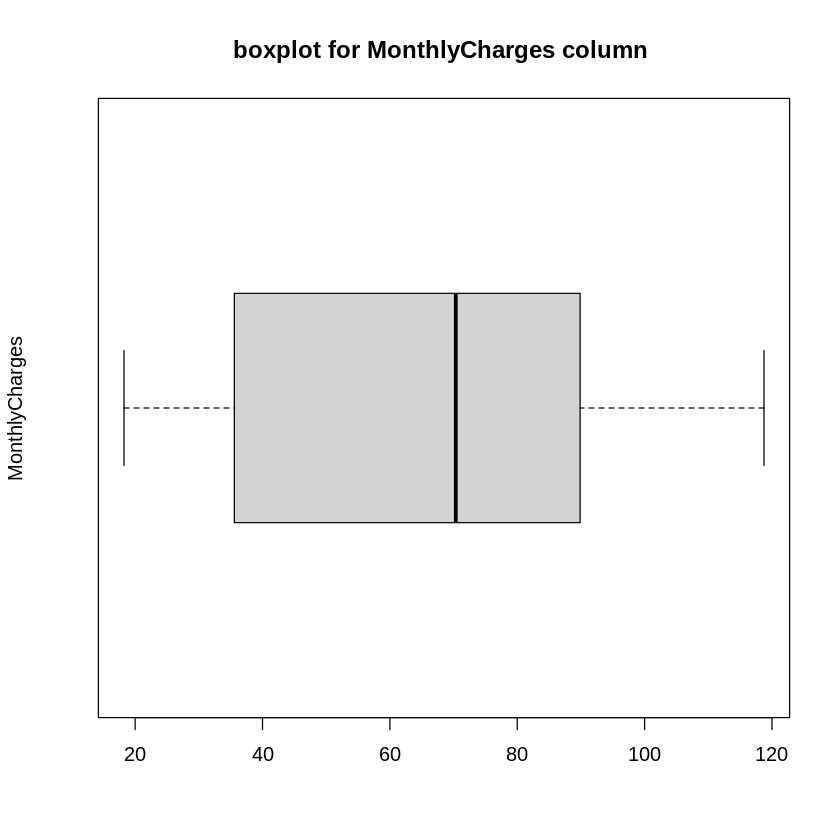

In [158]:
boxplot(churn_$MonthlyCharges,
        main = 'boxplot for MonthlyCharges column ', 
        ylab = 'MonthlyCharges',
        horizontal = TRUE )

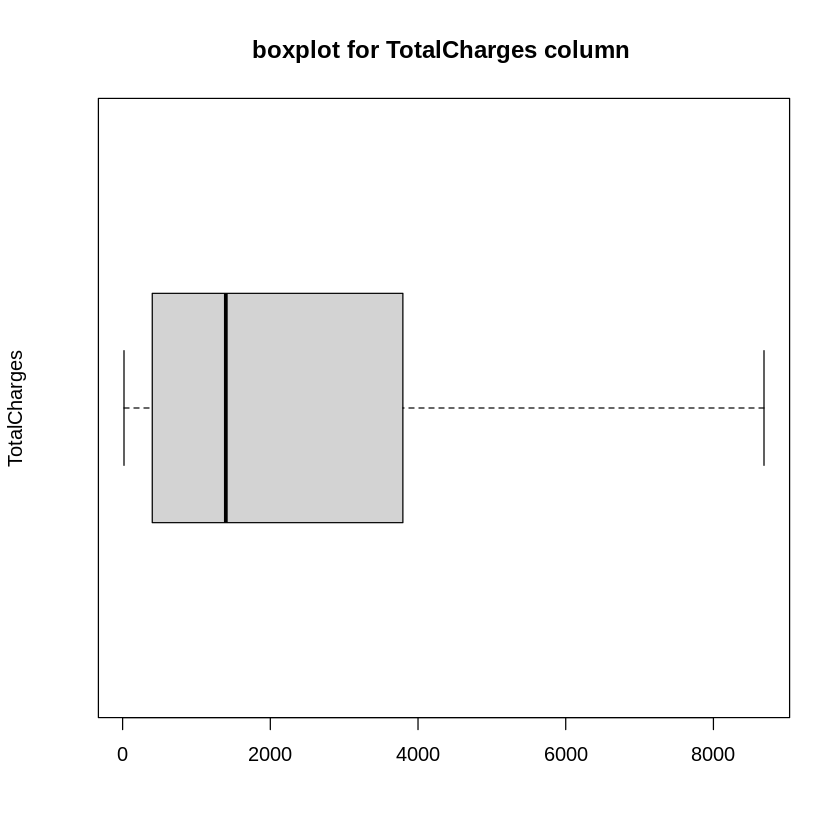

In [159]:

boxplot(churn_$TotalCharges,
        main = 'boxplot for TotalCharges column ', 
        ylab = 'TotalCharges',
        horizontal = TRUE )

## **2- Generate a scatterplot matrix to show the relationships between the variables and a correlation matrix to determine correlated attributes (5 points).**

In [ ]:
#install.packages("ggplot2")            # Packages need to be installed only once
install.packages("GGally")
 
library("ggplot2")                     # Load ggplot2 package
library("GGally")   

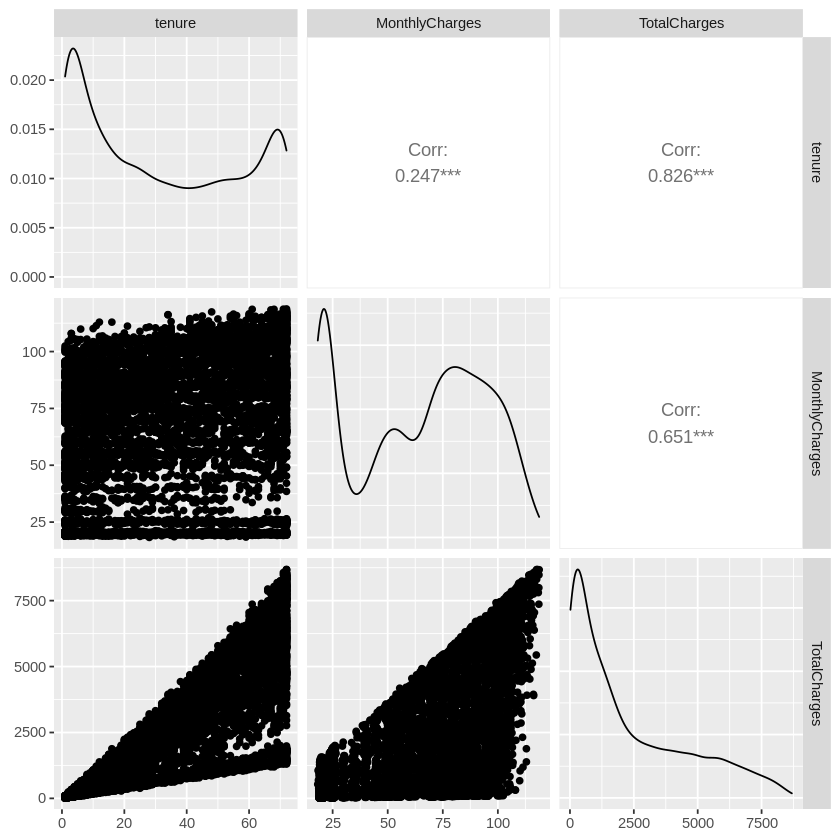

In [208]:
vars_df <- subset(churn_, select = -Churn)
ggpairs(vars_df[c('tenure', "MonthlyCharges" ,'TotalCharges')])                          # Apply ggpairs function

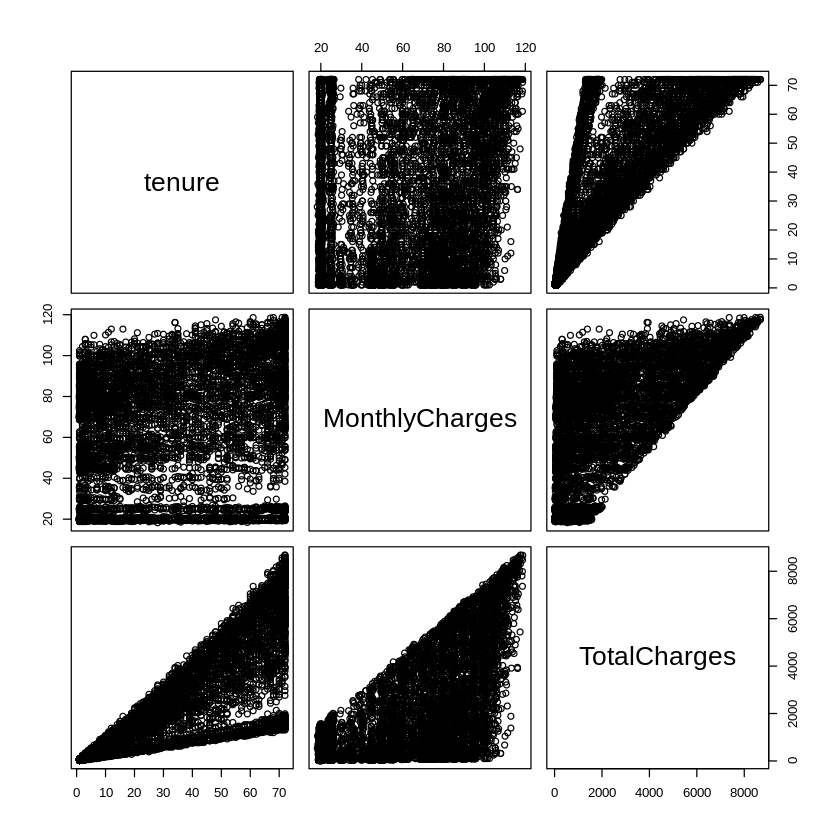

In [160]:
vars_df <- subset(churn_, select = -Churn)

pairs(vars_df[c('tenure', "MonthlyCharges" ,'TotalCharges')])

In [218]:

churn_df_vars <- sapply(vars_df,unclass)

#calculate correlation matrix
correlationMatrix <- cor(churn_df_vars)
# summarize the correlation matrix
print(correlationMatrix[,1:13])



                        gender SeniorCitizen       Partner   Dependents
gender            1.000000e+00  -0.001819391 -0.0013790513  0.010348917
SeniorCitizen    -1.819391e-03   1.000000000  0.0169566145 -0.210550061
Partner          -1.379051e-03   0.016956615  1.0000000000  0.452268886
Dependents        1.034892e-02  -0.210550061  0.4522688858  1.000000000
tenure            5.285372e-03   0.015683480  0.3819115091  0.163385967
PhoneService     -7.514980e-03   0.008391612  0.0183971893 -0.001077813
MultipleLines    -6.908086e-03   0.146287213  0.1427167732 -0.024974679
InternetService  -2.235856e-03  -0.032159672  0.0005125102  0.044029889
OnlineSecurity   -1.489946e-02  -0.127937251  0.1506101358  0.151198090
OnlineBackup     -1.191989e-02  -0.013354681  0.1530446751  0.090231179
DeviceProtection  1.348378e-03  -0.021123811  0.1656136861  0.079723393
TechSupport      -6.694581e-03  -0.151007053  0.1264881153  0.132530065
StreamingTV      -5.623667e-03   0.031018815  0.1366793250  0.04

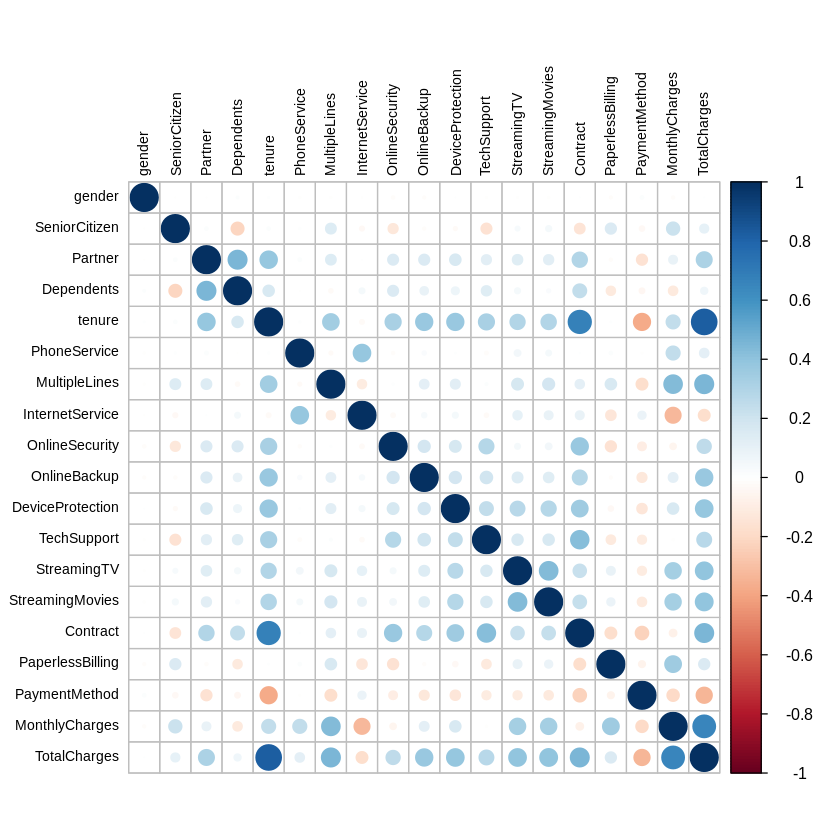

In [162]:

corrplot(cor(churn_df_vars),        # Correlation matrix
         method = "circle",               # Correlation plot method (method = number, circle, pie, or color)
         type = "full",                   # Correlation plot style (also "upper" and "lower")
         diag = TRUE,                     # If TRUE (default), adds the diagonal
         tl.col = "black",                # Labels color
         bg = "white",                    # Background color
         title = "",                      # Main title
         col = NULL,                      # Color palette
         tl.cex =0.7,
         cl.ratio =0.2)


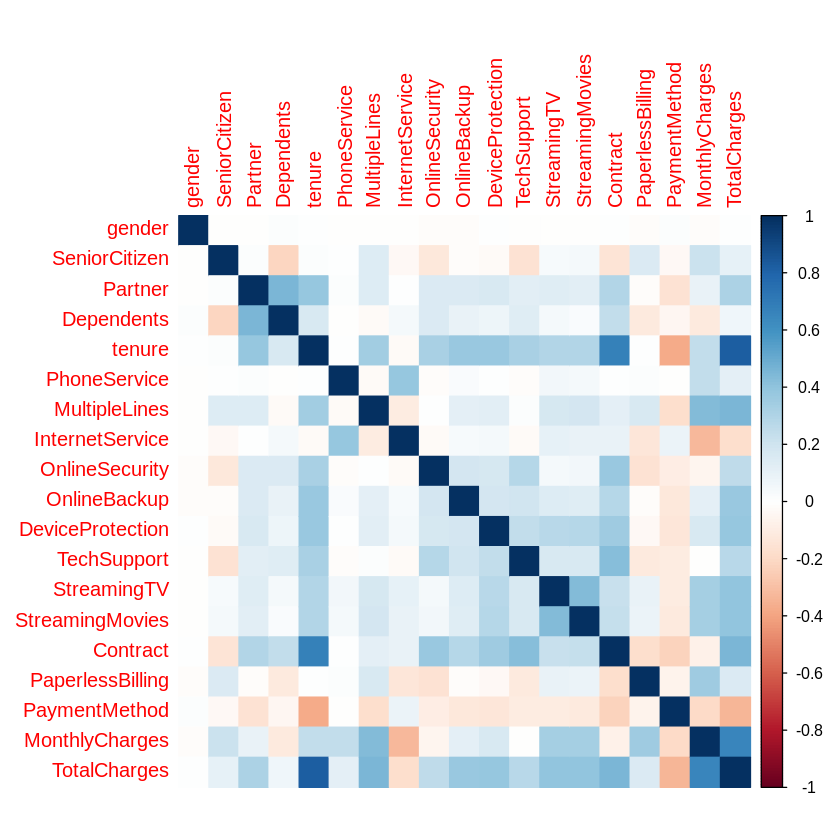

In [163]:
M = cor(churn_df_vars)
corrplot(M, method = 'color') # colorful number

### correlation between 
#### contract & tenure = 0.67
#### monthlyCharges % totalCharges = 0.65
#### tenure & totalcharge = 0.825






## **3- Split the dataset into 80 training /20 test set and fit a decision tree to the training data. Plot the tree, and interpret the results. (10 points)**

In [164]:
#Churn
#customerID       -0.017845432  
#gender           -0.008544643
#SeniorCitizen     0.150541053 * 
#Partner          -0.149981926 * 
#Dependents       -0.163128439 * 
#tenure           -0.354049359 ** 
#PhoneService      0.011691399 
#MultipleLines     0.038043274
#InternetService  -0.047097165
#OnlineSecurity   -0.289050176 ** 
#OnlineBackup     -0.195290209 * 
#DeviceProtection -0.177883195 * 
#TechSupport      -0.282232487 ** 
#StreamingTV      -0.036302722
#StreamingMovies  -0.038801748
#Contract         -0.396149533 **
#PaperlessBilling  0.191454321 * 
#PaymentMethod     0.107852015 * 
#MonthlyCharges    0.192858218 *
#TotalCharges     -0.199484084 *
#Churn             1.000000000

#based on the correlation matrix we make a subset consists of importantant columns

CHURN =subset(churn_ ,select = c('SeniorCitizen','Partner','Dependents','tenure',
                                 'OnlineSecurity','OnlineBackup', 'DeviceProtection'
                                 ,'TechSupport','Contract','PaperlessBilling',
                                 'PaymentMethod','MonthlyCharges','Churn')) 


 
glimpse(CHURN)

Rows: 7,032
Columns: 13
$ SeniorCitizen    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ Partner          <fct> Yes, No, No, No, No, No, No, No, Yes, No, Yes, No, Ye…
$ Dependents       <fct> No, No, No, No, No, No, Yes, No, No, Yes, Yes, No, No…
$ tenure           <int> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62, 13, 16, 58, 49, 2…
$ OnlineSecurity   <fct> No, Yes, Yes, Yes, No, No, No, Yes, No, Yes, Yes, No …
$ OnlineBackup     <fct> Yes, No, Yes, No, No, No, Yes, No, No, Yes, No, No in…
$ DeviceProtection <fct> No, Yes, No, Yes, No, Yes, No, No, Yes, No, No, No in…
$ TechSupport      <fct> No, No, No, Yes, No, No, No, No, Yes, No, No, No inte…
$ Contract         <fct> Month-to-month, One year, Month-to-month, One year, M…
$ PaperlessBilling <fct> Yes, No, Yes, No, Yes, Yes, Yes, No, Yes, No, Yes, No…
$ PaymentMethod    <fct> Electronic check, Mailed check, Mailed check, Bank tr…
$ MonthlyCharges   <dbl> 29.85, 56.95, 53.85, 42.30, 70.70, 99.65, 89.10, 29.7…
$ Churn         

In [165]:
table(CHURN$Churn) #check values present in the "Churn" column



  No  Yes 
5163 1869 

In [166]:
anyNA(CHURN)

[1] FALSE

In [167]:
set.seed(42)
sample_split <- sample.split(Y = CHURN$Churn, SplitRatio = 0.8)
train_set <- subset(x = CHURN, sample_split == TRUE)
test_set <- subset(x = CHURN, sample_split == FALSE)
dim(train_set)
dim(test_set)

[1] 5625   13

[1] 1407   13

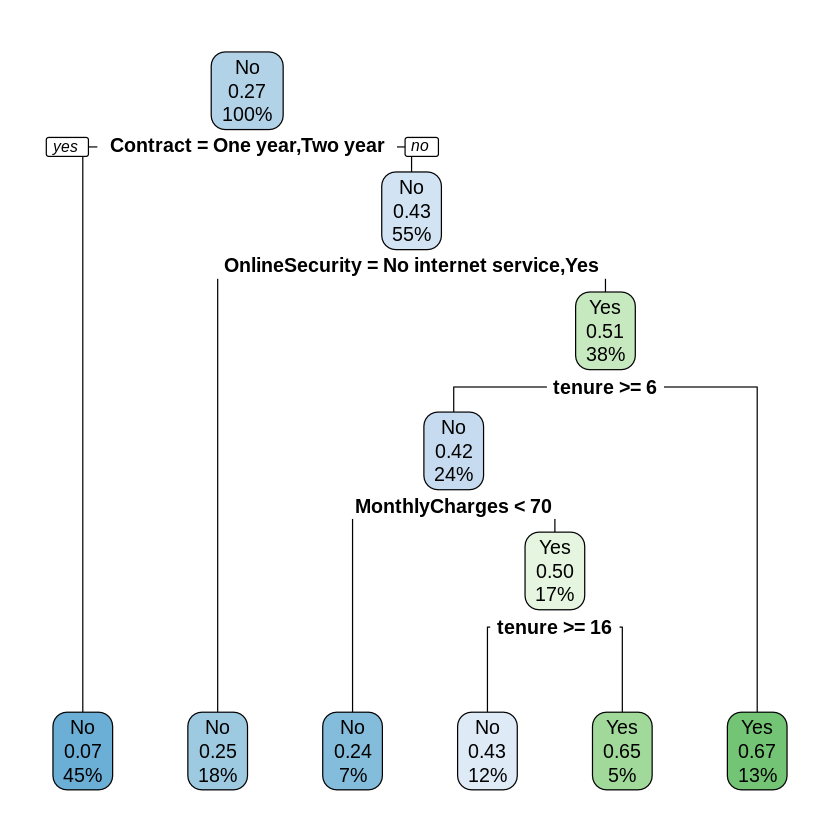

In [168]:
# build DT  
simple_model <- rpart(Churn ~ ., data = train_set, method = "class")
 #specify method as class since we are dealing with classification

#plot the model
rpart.plot(simple_model)



In [169]:
test_pred_simple <- predict(simple_model, newdata = test_set , type = "class")
confusionMatrix(test_pred_simple, test_set$Churn )  #check accuracy


Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  938 196
       Yes  95 178
                                          
               Accuracy : 0.7932          
                 95% CI : (0.7711, 0.8141)
    No Information Rate : 0.7342          
    P-Value [Acc > NIR] : 1.642e-07       
                                          
                  Kappa : 0.4202          
                                          
 Mcnemar's Test P-Value : 4.570e-09       
                                          
            Sensitivity : 0.9080          
            Specificity : 0.4759          
         Pos Pred Value : 0.8272          
         Neg Pred Value : 0.6520          
             Prevalence : 0.7342          
         Detection Rate : 0.6667          
   Detection Prevalence : 0.8060          
      Balanced Accuracy : 0.6920          
                                          
       'Positive' Class : No              
                              

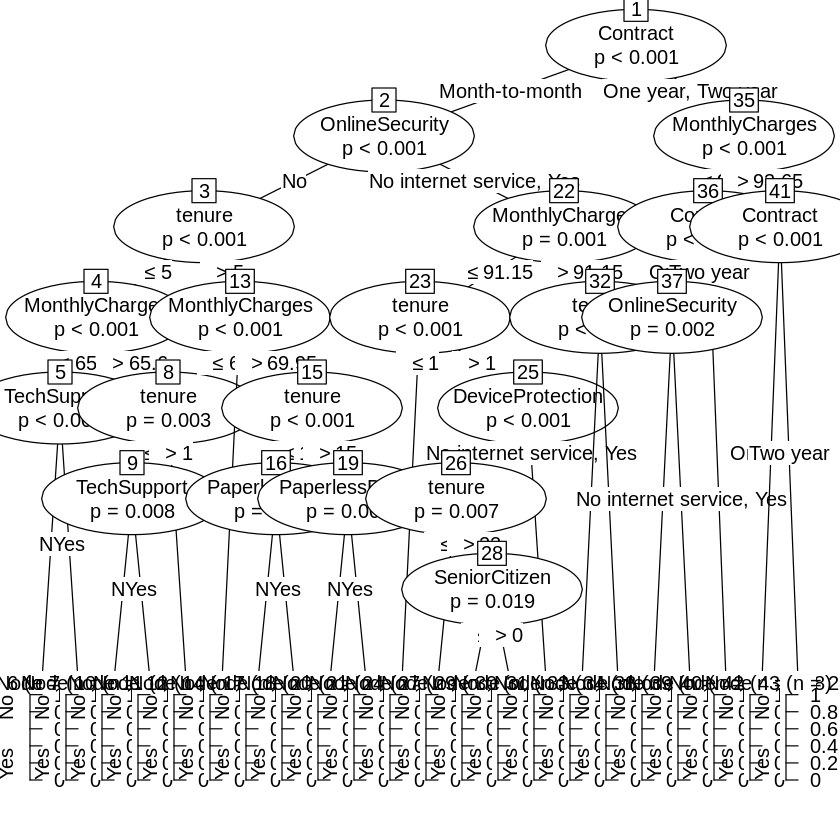

In [170]:
#plot conditional parting plot
ctree_ <- ctree(Churn ~ ., train_set)
plot(ctree_)

## **4- Describe the first few splits in the decision tree. Extract some rules. (5 points)**


the tree above classify customers as 45% of them who have contract for one or two years could churn with very low probability of 0.07  while the other 55% of customers who didn't hold a contract could churn with probability of 0.43 ,18% of those 55% of customers who didn’t have internet service at all or who get the online security service would churn with probability of 0.24 while the other 38% of 55% who didn't receive online service would churn with probability of 0.51. from the tree above we can extract some rules:
- customers who didn't hold contract would churn with high probability 
- customers who didn't receive online security may churn
- customers who have tenure less than 6 tends to churn more that the customers who have tenure more than 6


## **5- Try different ways to improve your decision tree algorithm (e.g., use different splitting strategies,prune tree after splitting). Does pruning the tree improves he accuracy? (5 points)**

CART 

5625 samples
  12 predictor
   2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 5063, 5062, 5063, 5062, 5063, 5063, ... 
Resampling results across tuning parameters:

  cp            Accuracy   Kappa    
  0.0000000000  0.7616015  0.3621680
  0.0009053748  0.7834700  0.4043642
  0.0018107496  0.7871987  0.4029709
  0.0027161245  0.7875524  0.3967602
  0.0036214993  0.7891529  0.3859258
  0.0045268741  0.7877313  0.3802114
  0.0054322489  0.7891529  0.3943304
  0.0063376237  0.7900425  0.4039065
  0.0072429985  0.7868416  0.3979737
  0.0081483734  0.7868416  0.3979737
  0.0090537482  0.7866633  0.3953551
  0.0099591230  0.7855951  0.3881902
  0.0108644978  0.7822168  0.3800632
  0.0117698726  0.7795497  0.3603749
  0.0126752475  0.7788392  0.3511684
  0.0135806223  0.7788392  0.3475988
  0.0144859971  0.7788392  0.3475988
  0.0153913719  0.7788392  0.3475988
  0.0162967467  0.7802602  0.3468210
  0.0172021215  0.7802602  0

n= 5625 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 5625 1495 No (0.7342222 0.2657778)  
   2) tenure>=16.5 3593  565 No (0.8427498 0.1572502) *
   3) tenure< 16.5 2032  930 No (0.5423228 0.4576772)  
     6) MonthlyCharges< 68.625 1120  340 No (0.6964286 0.3035714)  
      12) tenure>=3.5 620  117 No (0.8112903 0.1887097) *
      13) tenure< 3.5 500  223 No (0.5540000 0.4460000)  
        26) OnlineSecurityNo internet service>=0.5 216   63 No (0.7083333 0.2916667) *
        27) OnlineSecurityNo internet service< 0.5 284  124 Yes (0.4366197 0.5633803) *
     7) MonthlyCharges>=68.625 912  322 Yes (0.3530702 0.6469298)  
      14) OnlineSecurityYes>=0.5 118   44 No (0.6271186 0.3728814)  
        28) MonthlyCharges< 94.025 88   23 No (0.7386364 0.2613636) *
        29) MonthlyCharges>=94.025 30    9 Yes (0.3000000 0.7000000) *
      15) OnlineSecurityYes< 0.5 794  248 Yes (0.3123426 0.6876574) *

Accuracy,Kappa,Resample
<dbl>,<dbl>,<chr>
0.7882562,0.3869016,Fold01
0.7815275,0.3849508,Fold09
0.8081705,0.4710764,Fold10
0.7815275,0.3548090,Fold04
0.7868561,0.3928610,Fold08
0.7758007,0.3297492,Fold06
0.7918149,0.4029853,Fold07
0.7989324,0.4497739,Fold05
0.8028419,0.4551375,Fold02


Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  929 187
       Yes 104 187
                                          
               Accuracy : 0.7932          
                 95% CI : (0.7711, 0.8141)
    No Information Rate : 0.7342          
    P-Value [Acc > NIR] : 1.642e-07       
                                          
                  Kappa : 0.4297          
                                          
 Mcnemar's Test P-Value : 1.533e-06       
                                          
            Sensitivity : 0.8993          
            Specificity : 0.5000          
         Pos Pred Value : 0.8324          
         Neg Pred Value : 0.6426          
             Prevalence : 0.7342          
         Detection Rate : 0.6603          
   Detection Prevalence : 0.7932          
      Balanced Accuracy : 0.6997          
                                          
       'Positive' Class : No              
                              

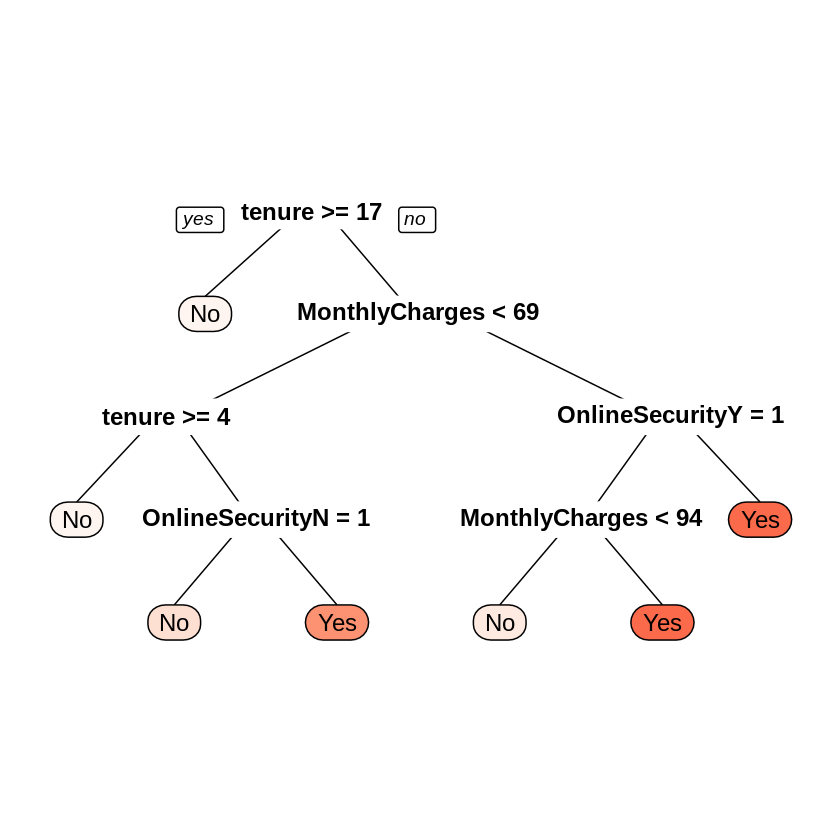

In [171]:
# using  gini splitting method 
set.seed(123) #generates a reproducible random sampling

#specify the cross-validation method
ctrl <- trainControl(method = "cv", number = 10)

#fit a decision tree model and use k-fold CV to evaluate performance
dtree_fit_gini <- train(Churn ~ . , data = train_set,
                        method = "rpart",
                        parms = list(split = "gini"), 
                        trControl = ctrl,
                        tuneLength = 100)

#Step 5: Evaluate - view summary of k-fold CV               
print(dtree_fit_gini) #metrics give us an idea of how well the model performed 
#on previously unseen data

#view final model
dtree_fit_gini$finalModel
prp(dtree_fit_gini$finalModel, box.palette = "Reds", tweak = 1.2) #view the tree using prop() function

#view predictions for each fold
dtree_fit_gini$resample

#Check accuracy
test_pred_gini <- predict(dtree_fit_gini, newdata = test_set)
confusionMatrix(test_pred_gini, test_set$Churn )  #check accuracy


Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  977 253
       Yes  56 121
                                          
               Accuracy : 0.7804          
                 95% CI : (0.7578, 0.8018)
    No Information Rate : 0.7342          
    P-Value [Acc > NIR] : 3.651e-05       
                                          
                  Kappa : 0.3237          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9458          
            Specificity : 0.3235          
         Pos Pred Value : 0.7943          
         Neg Pred Value : 0.6836          
             Prevalence : 0.7342          
         Detection Rate : 0.6944          
   Detection Prevalence : 0.8742          
      Balanced Accuracy : 0.6347          
                                          
       'Positive' Class : No              
                              

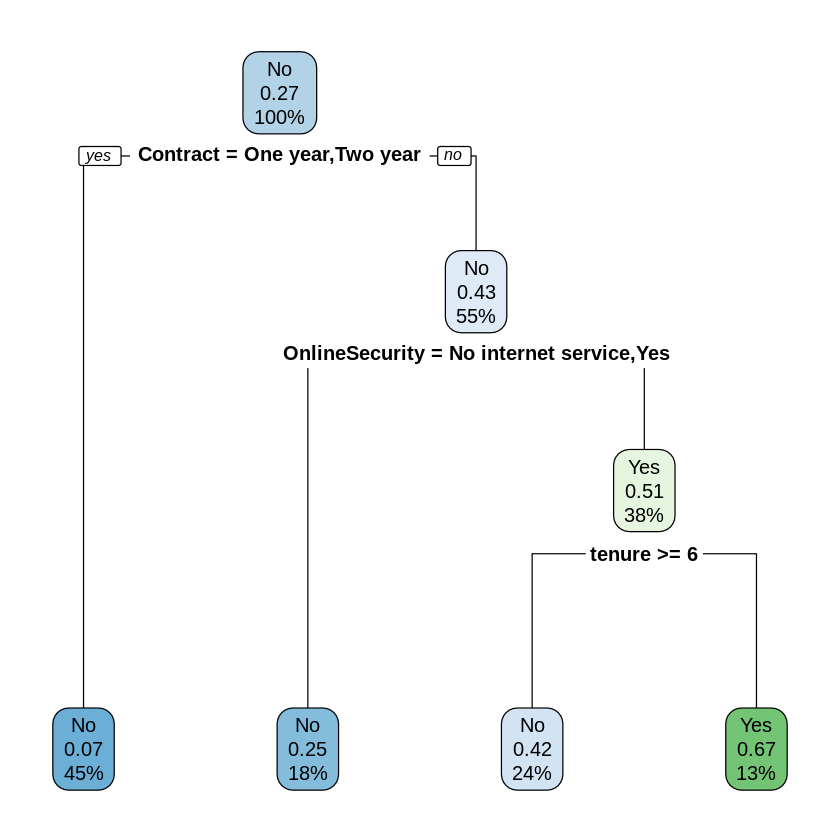

In [178]:
# Grow a tree with minsplit of 100 and max depth of 8
hr_model_preprun <- rpart(Churn ~ ., data = train_set, method = "class", 
                   control = rpart.control(cp = 0.0084, maxdepth = 3,minsplit = 2))
rpart.plot(hr_model_preprun)
# Compute the accuracy of the pruned tree
test_set$pred <- predict(hr_model_preprun, test_set, type = "class")
#accuracy_preprun <- mean(test$pred == test_set$Churn)
confusionMatrix(test_set$pred , test_set$Churn)

[1] 0.7803838

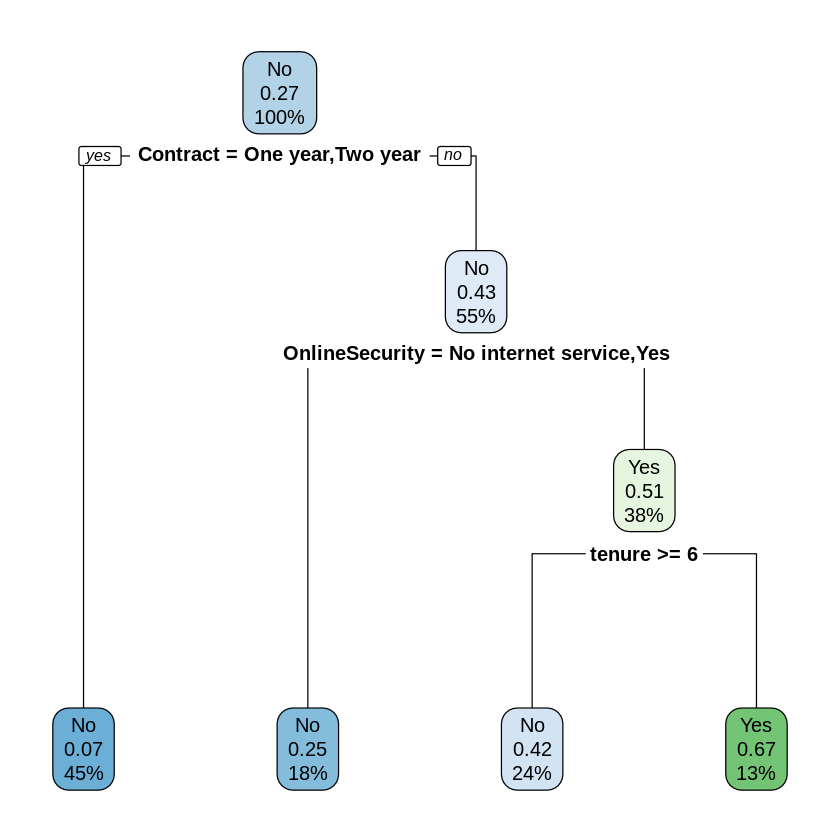

In [179]:

# Prune the hr_base_model based on the optimal cp value
hr_model_pruned <- prune(hr_model_preprun, cp = 0.0084 )
rpart.plot(hr_model_pruned)
# Compute the accuracy of the pruned tree
test_set$pred <- predict(hr_model_pruned, test_set, type = "class")
mean(test_set$pred == test_set$Churn)

#data.frame(base_accuracy, accuracy_preprun, accuracy_postprun)

## **6- Train an XGboost model using 10-fold cross-validation repeated 3 times and a hyperparameter grid search to train the optimal model. Evaluate the performance. (5 points)**

In [105]:
CHURN_XGB = transform(CHURN, Churn = factor(Churn, 
       levels = c("No" ,"Yes"),
       labels = c(0,1)))
CHURN_XGB$Churn <- as.integer(CHURN_XGB$Churn) - 1
head(CHURN_XGB)

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
1,0,Yes,No,1,No,Yes,No,No,Month-to-month,Yes,Electronic check,29.85,0
2,0,No,No,34,Yes,No,Yes,No,One year,No,Mailed check,56.95,0
3,0,No,No,2,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,53.85,1
4,0,No,No,45,Yes,No,Yes,Yes,One year,No,Bank transfer (automatic),42.30,0
5,0,No,No,2,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,1
6,0,No,No,8,No,No,Yes,No,Month-to-month,Yes,Electronic check,99.65,1


In [106]:
Partner<-as.numeric(CHURN_XGB$Partner)
Dependents<-as.numeric(factor(CHURN_XGB$Dependents))
OnlineSecurity<-as.numeric(factor(CHURN_XGB$OnlineSecurity))
OnlineBackup<-as.numeric(factor(CHURN_XGB$OnlineBackup))
DeviceProtection<-as.numeric(factor(CHURN_XGB$DeviceProtection))
TechSupport	<-as.numeric(factor(CHURN_XGB$TechSupport)	)
Contract<-as.numeric(factor(CHURN_XGB$Contract))
PaperlessBilling<-as.numeric(factor(CHURN_XGB$PaperlessBilling))
PaymentMethod<-as.numeric(factor(CHURN_XGB$PaymentMethod))

MonthlyCharges<-as.numeric(CHURN_XGB$MonthlyCharges)
tenure<-as.numeric(CHURN_XGB$tenure)
SeniorCitizen<-as.numeric(CHURN_XGB$SeniorCitizen)

df_xg <-data.frame(Partner,Dependents,OnlineSecurity,OnlineBackup,
                  DeviceProtection,TechSupport,Contract,
                  PaperlessBilling,SeniorCitizen,PaymentMethod,MonthlyCharges,tenure)
attach(df_xg)
df_xg<-as.matrix(df_xg)

IsChurn<-as.numeric(CHURN_XGB$Churn)


The following objects are masked _by_ .GlobalEnv:

    Contract, Dependents, DeviceProtection, MonthlyCharges,
    OnlineBackup, OnlineSecurity, PaperlessBilling, Partner,
    PaymentMethod, SeniorCitizen, TechSupport, tenure


The following objects are masked from df_xg (pos = 4):

    Contract, Dependents, DeviceProtection, MonthlyCharges,
    OnlineBackup, OnlineSecurity, PaperlessBilling, Partner,
    PaymentMethod, SeniorCitizen, TechSupport, tenure




In [ ]:
install.packages('xgboost')
library(xgboost)

In [114]:
train <- df_xg[1:5625,]
test <- df_xg[5625:7032,]
train =as(train, "dgCMatrix")
test =as(test, "dgCMatrix")
Ischrun_train = IsChurn[1:5625]
Ischurn_test  = IsChurn[5625:7032]

In [108]:
data <- xgb.DMatrix(data =train  , label = Ischrun_train )

In [220]:
searchGridSubCol <- expand.grid(subsample = c(0.5, 0.6), 
                                colsample_bytree = c(0.5, 0.6),
                                max_depth = c(3, 4,5 ,6),
                                min_child = seq(1), 
                                eta = c(0.1 ,0.3, 0.01,0.001)
)

Hyperparameters <- apply(searchGridSubCol, 1, function(parameterList){
  
  #Extract Parameters to test
  subsample <- parameterList[["subsample"]]
  colsample_bytree <- parameterList[["colsample_bytree"]]
  max_depth <- parameterList[["max_depth"]]
  eta <- parameterList[["eta"]]
  min_child <- parameterList[["min_child"]]
  xgboostModelCV <- xgb.cv(data =  data, nrounds = 3, nfold = 10, showsd = TRUE, 
                       feval = accuracy, verbose = TRUE,
                     "objective" = "binary:logistic", "max.depth" = max_depth, "eta" = eta,                               
                     "subsample" = subsample, "colsample_bytree" = colsample_bytree
                      , print_every_n = 10, "min_child_weight" = min_child, booster = "gbtree",
                      early_stopping_rounds = 10,maximize=TRUE
                     )
  
  val_score <- as.data.frame(xgboostModelCV$evaluation_log)
  test_acc <- tail(val_score$test_accuracy_mean, 1)
  train_acc <- tail(val_score$train_accuracy_mean,1)
  output <- return(c(test_acc, train_acc, subsample, colsample_bytree, max_depth, eta, min_child))})

[1]	train-accuracy:0.735467+0.001574	test-accuracy:0.735468+0.014177 
Multiple eval metrics are present. Will use test_accuracy for early stopping.
Will train until test_accuracy hasn't improved in 10 rounds.

[3]	train-accuracy:0.735467+0.001574	test-accuracy:0.735468+0.014177 
[1]	train-accuracy:0.735467+0.001816	test-accuracy:0.735462+0.016341 
Multiple eval metrics are present. Will use test_accuracy for early stopping.
Will train until test_accuracy hasn't improved in 10 rounds.

[3]	train-accuracy:0.735467+0.001816	test-accuracy:0.735462+0.016341 
[1]	train-accuracy:0.735467+0.001877	test-accuracy:0.735466+0.016880 
Multiple eval metrics are present. Will use test_accuracy for early stopping.
Will train until test_accuracy hasn't improved in 10 rounds.

[3]	train-accuracy:0.735467+0.001877	test-accuracy:0.735466+0.016880 
[1]	train-accuracy:0.735467+0.001813	test-accuracy:0.735479+0.016319 
Multiple eval metrics are present. Will use test_accuracy for early stopping.
Will train u

In [137]:
output <- as.data.frame(t(Hyperparameters))
varnames <- c("test_acc", "train_acc", "subsample", "colsample_bytree", "max_depth", "eta", "min_child")
names(output) <- varnames
head(output)

,test_acc,train_acc,subsample,colsample_bytree,max_depth,eta,min_child
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.7791951,0.7867459,0.5,0.5,3,0.1,1
2,0.7772414,0.7826376,0.6,0.5,3,0.1,1
3,0.7777779,0.7852842,0.5,0.6,3,0.1,1
4,0.7790203,0.7856195,0.6,0.6,3,0.1,1
5,0.7870172,0.7915453,0.5,0.5,4,0.1,1
6,0.7864980,0.7951009,0.6,0.5,4,0.1,1


In [133]:
best_param = data.frame(output[which.max(output$test_acc) ,])
best_param

,test_acc,train_acc,subsample,colsample_bytree,max_depth,eta,min_child
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
32,0.7948411,0.8088689,0.6,0.6,6,0.3,1


In [ ]:

params <- list(max_depth = 5, eta = 0.3, verbose = 0, nthread = 2,
              objective = "binary:logistic" , max.depth = 5 ,
              min_child_weight = 1 , subsample = 0.6 , colsample_bytree = 0.5)

xgb_model <- xgb.train( params = params, data = data ,nrounds = 3,
                 nfold = 10, eval_metric = accuracy, stratified = T,
                 prediction = T , maximize = F)

In [130]:
#model prediction
xgbpred <- predict(xgb_model,test)
prediction <- as.numeric(xgbpred > 0.5) 
confusionMatrix(as.factor(prediction) ,as.factor(Ischurn_test))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 946 210
         1  81 171
                                          
               Accuracy : 0.7933          
                 95% CI : (0.7712, 0.8142)
    No Information Rate : 0.7294          
    P-Value [Acc > NIR] : 1.737e-08       
                                          
                  Kappa : 0.414           
                                          
 Mcnemar's Test P-Value : 6.214e-14       
                                          
            Sensitivity : 0.9211          
            Specificity : 0.4488          
         Pos Pred Value : 0.8183          
         Neg Pred Value : 0.6786          
             Prevalence : 0.7294          
         Detection Rate : 0.6719          
   Detection Prevalence : 0.8210          
      Balanced Accuracy : 0.6850          
                                          
       'Positive' Class : 0               
                              

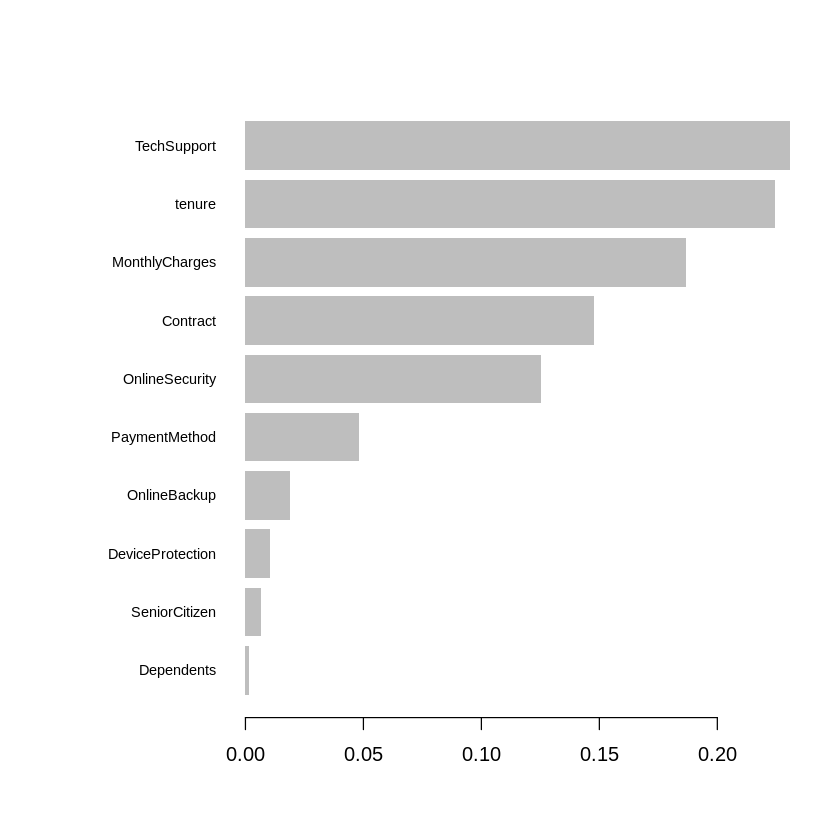

In [138]:
# Importance Matrix
#An importance matrix is also generated to identify the most important influencing
# factors on customer churn :
importance_matrix <- xgb.importance(model = xgb_model)
xgb.plot.importance(importance_matrix = importance_matrix)

In [ ]:
    # Gain: Illustrates the contribution of a feature for each tree in the model,
    #  with a higher value illustrating greater importance for predicting 
    #  the outcome variable.
    # Cover: Number of relative observations related to the feature in question.
    # Frequency: Number of times a feature occurs across the trees in the model.
    print(importance_matrix)


             Feature        Gain        Cover   Frequency  Importance
 1:         Contract 0.488326879 0.2176083628 0.035211268 0.488326879
 2:   MonthlyCharges 0.152468050 0.2609859822 0.316901408 0.152468050
 3:           tenure 0.106025676 0.1368175897 0.140845070 0.106025676
 4:   OnlineSecurity 0.094355178 0.1183636520 0.028169014 0.094355178
 5:     TotalCharges 0.077095925 0.1392244873 0.281690141 0.077095925
 6:      TechSupport 0.040871897 0.0462965705 0.021126761 0.040871897
 7: PaperlessBilling 0.015778010 0.0255633130 0.056338028 0.015778010
 8:    PaymentMethod 0.012619255 0.0293923068 0.049295775 0.012619255
 9:    SeniorCitizen 0.005089890 0.0106559757 0.028169014 0.005089890
10:     OnlineBackup 0.004231218 0.0140823738 0.021126761 0.004231218
11:       Dependents 0.001713667 0.0005488722 0.014084507 0.001713667
12: DeviceProtection 0.001424354 0.0004605140 0.007042254 0.001424354


### ***7- Build a multilayer perceptron with 5 nodes at the hidden layer. Use a standard or normalization to scale the variables. Try changing the activation function, varying the neurons, learning rate, epochs or removing the bias. What effects does any of these have on the result? With a confusion matrix, evaluate the performance of the NN model based on sensitivity, specificity & accuracy (10 points)***

In [ ]:
install.packages('caTools')
library(caTools)
install.packages('h2o')
library(h2o)

In [140]:
CHURN =subset(churn_ ,select = c('SeniorCitizen','Partner','Dependents','tenure',
                                 'OnlineSecurity','OnlineBackup', 'DeviceProtection'
                                 ,'TechSupport','Contract','PaperlessBilling',
                                 'PaymentMethod','MonthlyCharges', 'Churn'))


In [141]:
Churn_nn <- data.frame(sapply(CHURN ,unclass))
Churn_nn$Churn[Churn_nn$Churn == 1] <- 0
Churn_nn$Churn[Churn_nn$Churn == 2] <- 1
head(Churn_nn)

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,2,1,1,1,3,1,1,1,2,3,29.85,0
2,0,1,1,34,3,1,3,1,2,1,4,56.95,0
3,0,1,1,2,3,3,1,1,1,2,4,53.85,1
4,0,1,1,45,3,1,3,3,2,1,1,42.30,0
5,0,1,1,2,1,1,1,1,1,2,3,70.70,1
6,0,1,1,8,1,1,3,1,1,2,3,99.65,1


In [142]:
# Splitting the dataset into the Training set and Test set

set.seed(123)
split = sample.split(Churn_nn$Churn, SplitRatio = 0.8)
training_set = subset(Churn_nn, split == TRUE)
test_set = subset(Churn_nn, split == FALSE)

# Feature Scaling
training_set[-13] = scale(training_set[-13])
test_set[-13] = scale(test_set[-13])

head(training_set)

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.4392798,1.0515494,-0.6480905,-1.2836313,-0.9152948,1.239213,-1.028387,-0.9223572,-0.8282759,0.8279637,0.3970348,-1.1642268,0
2,-0.4392798,-0.9508086,-0.6480905,0.0627476,1.4075264,-1.028746,1.239669,-0.9223572,0.3731300,-1.2075677,1.3303073,-0.2611425,0
3,-0.4392798,-0.9508086,-0.6480905,-1.2428319,1.4075264,1.239213,-1.028387,-0.9223572,-0.8282759,0.8279637,1.3303073,-0.3644474,1
4,-0.4392798,-0.9508086,-0.6480905,0.5115406,1.4075264,-1.028746,1.239669,1.3953820,0.3731300,-1.2075677,-1.4695101,-0.7493412,0
5,-0.4392798,-0.9508086,-0.6480905,-1.2428319,-0.9152948,-1.028746,-1.028387,-0.9223572,-0.8282759,0.8279637,0.3970348,0.1970645,1
6,-0.4392798,-0.9508086,-0.6480905,-0.9980358,-0.9152948,-1.028746,1.239669,-0.9223572,-0.8282759,0.8279637,0.3970348,1.1617985,1


In [ ]:
# Fitting ANN to the Training set
h2o.init(nthreads = -1)
model = h2o.deeplearning(y = 'Churn',
                         training_frame = as.h2o(training_set),
                         activation = 'Rectifier',
                         hidden = c(5,5),
                         epochs = 100,
                         train_samples_per_iteration = -2,
                         nfolds = 10)

# Predicting the Test set results
y_pred = h2o.predict(model, newdata = as.h2o(test_set[-13]))
y_pred = (y_pred > 0.5)
y_pred_nn = as.vector(y_pred)
# h2o.shutdown()

In [145]:

confusionMatrix(as.factor(y_pred_nn) ,as.factor(test_set[,13]))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 910 176
         1 123 198
                                          
               Accuracy : 0.7875          
                 95% CI : (0.7652, 0.8086)
    No Information Rate : 0.7342          
    P-Value [Acc > NIR] : 2.136e-06       
                                          
                  Kappa : 0.4298          
                                          
 Mcnemar's Test P-Value : 0.002636        
                                          
            Sensitivity : 0.8809          
            Specificity : 0.5294          
         Pos Pred Value : 0.8379          
         Neg Pred Value : 0.6168          
             Prevalence : 0.7342          
         Detection Rate : 0.6468          
   Detection Prevalence : 0.7719          
      Balanced Accuracy : 0.7052          
                                          
       'Positive' Class : 0               
                              

In [ ]:
# Fitting ANN to the Training set
h2o.init(nthreads = -1)
model = h2o.deeplearning(y = 'Churn',
                         training_frame = as.h2o(training_set),
                         activation = 'tanh',
                         hidden = c(5,5),
                         epochs = 100,
                         train_samples_per_iteration = -2,
                         nfolds = 10)

# Predicting the Test set results
y_pred = h2o.predict(model, newdata = as.h2o(test_set[-14]))
y_pred = (y_pred > 0.5)
y_pred_nn = as.vector(y_pred)
# h2o.shutdown()

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 minutes 50 seconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.34.0.3 
    H2O cluster version age:    27 days  
    H2O cluster name:           H2O_started_from_R_root_fdw007 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.17 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 4.1.1 (2021-08-10) 

  |======================================================================| 100%
  |======================================================================| 

In [ ]:
confusionMatrix(as.factor(y_pred_nn) ,as.factor(test_set[,13]))


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 899 168
         1 134 206
                                         
               Accuracy : 0.7854         
                 95% CI : (0.763, 0.8066)
    No Information Rate : 0.7342         
    P-Value [Acc > NIR] : 5.223e-06      
                                         
                  Kappa : 0.4337         
                                         
 Mcnemar's Test P-Value : 0.05757        
                                         
            Sensitivity : 0.8703         
            Specificity : 0.5508         
         Pos Pred Value : 0.8425         
         Neg Pred Value : 0.6059         
             Prevalence : 0.7342         
         Detection Rate : 0.6389         
   Detection Prevalence : 0.7584         
      Balanced Accuracy : 0.7105         
                                         
       'Positive' Class : 0              
                                         

In [146]:
h2o.shutdown()

Are you sure you want to shutdown the H2O instance running at http://localhost:54321/ (Y/N)? y


### **8- Carry out a ROC analysis to compare the performance of the DT, XGboost & NN techniques. Plot the ROC graph of the models**

In [ ]:
install.packages('pROC')
library(pROC)

In [ ]:
install.packages("plotROC")

In [149]:
#Plotting the ROCcurve
library(ggplot2)
library(plotROC)



Attaching package: ‘plotROC’


The following object is masked from ‘package:pROC’:

    ggroc




Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = tes, predictor = ppr)

Data: ppr in 1033 controls (tes 0) < 374 cases (tes 1).
Area under the curve: 0.7052


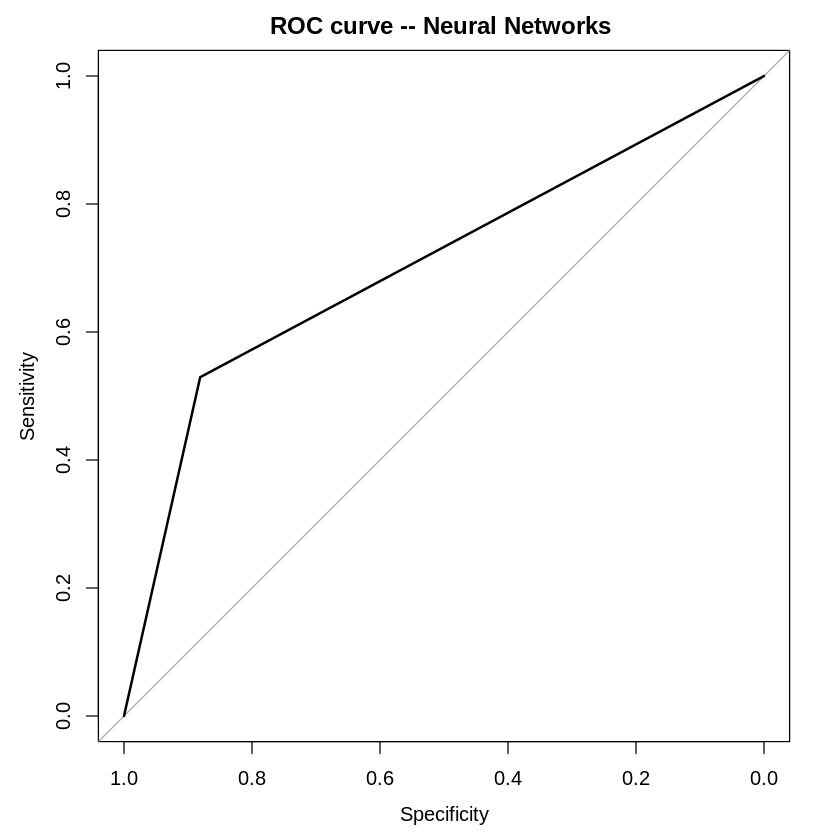

In [150]:
tes = test_set[,13]
ppr = y_pred_nn
roc_score=roc(tes, ppr) #AUC score
print(roc_score)
plot(roc_score ,main ="ROC curve -- Neural Networks ")

Setting levels: control = 1, case = 2

Setting direction: controls < cases




Call:
roc.default(response = pre, predictor = act)

Data: act in 1134 controls (pre 1) < 273 cases (pre 2).
Area under the curve: 0.7396


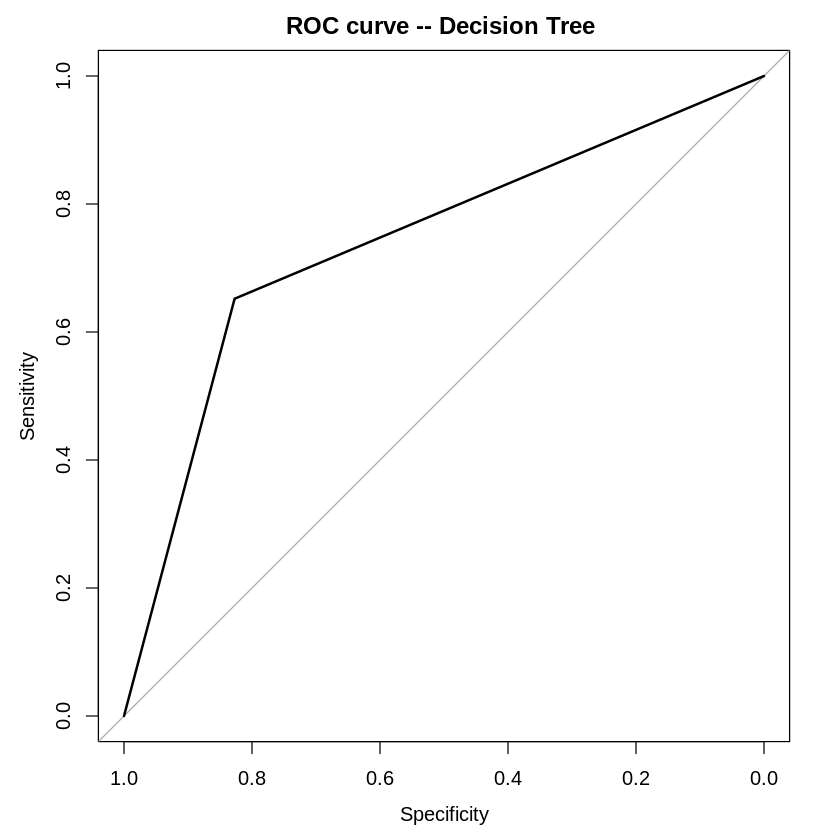

In [ ]:
pre =as.numeric(test_pred_simple)
act = as.numeric(test_set$Churn)
roc_score=roc( pre, act ) #AUC score
print(roc_score)

plot(roc_score ,main ="ROC curve -- Decision Tree ")

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = te, predictor = pr)

Data: pr in 1027 controls (te 0) < 381 cases (te 1).
Area under the curve: 0.7079


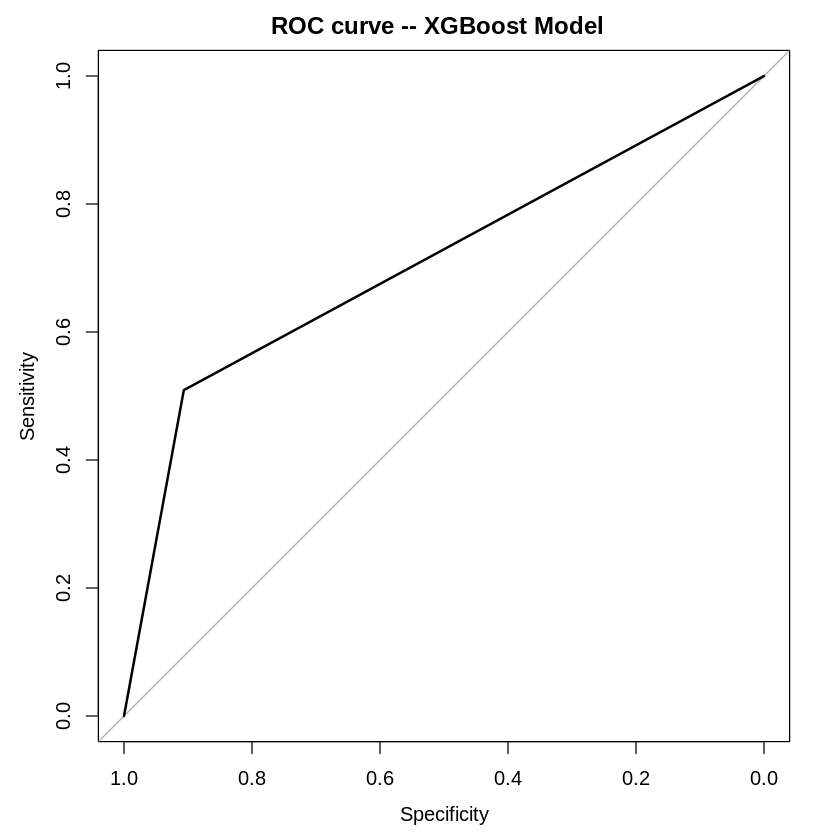

In [ ]:
te = Ischurn_test
pr = prediction
roc_score=roc(te, pr) #AUC score
print(roc_score)
plot(roc_score ,main ="ROC curve -- XGBoost Model  ")

# clustering

### **1- Perform k‐means clustering, specifying k = 2 clusters and plot. Determine the attribute that is most correlated with the clusters (Hint: save the labels of the cluster into a data frame and use heat map to find the most correlated attribute). (10 points)**

In [ ]:
install.packages("ggpubr")

In [ ]:
install.packages("factoextra")

In [ ]:
install.packages("fpc")

In [ ]:
library(ggpubr)
library(factoextra)
library(cluster)
library(fpc)

In [184]:
Shopping_df <- load_google_drive_data("https://drive.google.com/file/d/1SGp7lNs9wWkLddYCK4YJQNqaoBeJqVih/view?usp=sharing" )
Shopping_df <- subset(Shopping_df ,select = - c(CustomerID ,Gender))
head(Shopping_df)

,Age,Annual.Income..k..,Spending.Score..1.100.
,<int>,<int>,<int>
1,19,15,39
2,21,15,81
3,20,16,6
4,23,16,77
5,31,17,40
6,22,17,76


In [185]:
str(Shopping_df)

'data.frame':	200 obs. of  3 variables:
 $ Age                   : int  19 21 20 23 31 22 35 23 64 30 ...
 $ Annual.Income..k..    : int  15 15 16 16 17 17 18 18 19 19 ...
 $ Spending.Score..1.100.: int  39 81 6 77 40 76 6 94 3 72 ...


In [186]:
summary(Shopping_df)

      Age        Annual.Income..k.. Spending.Score..1.100.
 Min.   :18.00   Min.   : 15.00     Min.   : 1.00         
 1st Qu.:28.75   1st Qu.: 41.50     1st Qu.:34.75         
 Median :36.00   Median : 61.50     Median :50.00         
 Mean   :38.85   Mean   : 60.56     Mean   :50.20         
 3rd Qu.:49.00   3rd Qu.: 78.00     3rd Qu.:73.00         
 Max.   :70.00   Max.   :137.00     Max.   :99.00         

In [187]:
anyNA(Shopping_df)

[1] FALSE

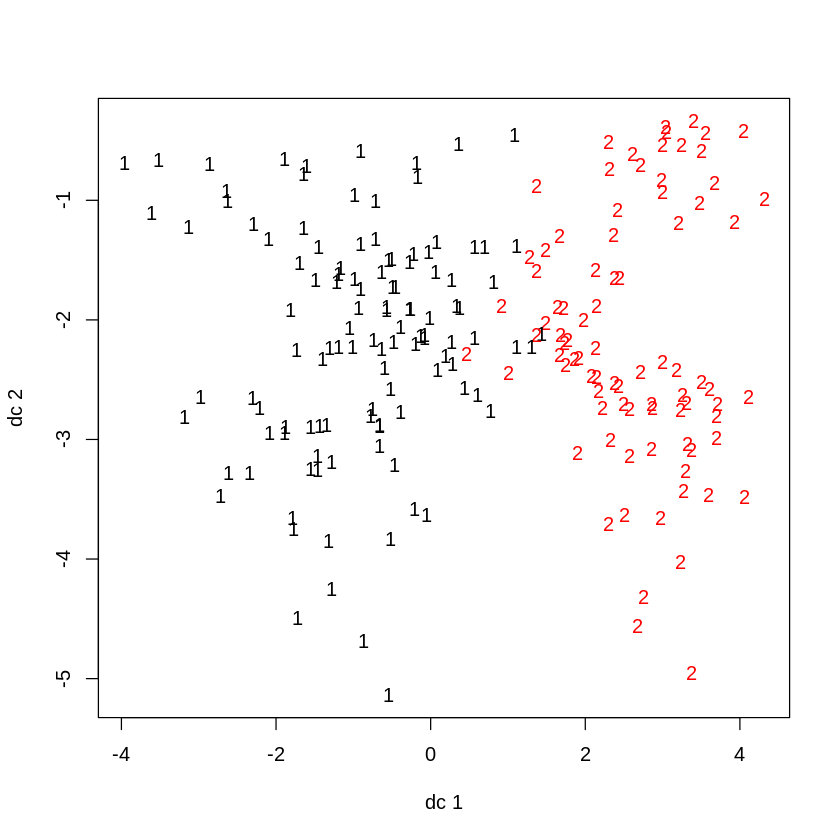

In [188]:
# Fitting K-Means to the Shopping_df dataset
set.seed(29)
clus = kmeans(x = Shopping_df, centers = 2)
y_kmeans = clus$cluster
plotcluster(Shopping_df, clus$cluster)

In [189]:
y_kmeans_df = data.frame(y_kmeans)

In [190]:
shop_cust_df = Shopping_df
shop_cust_df$labels = y_kmeans
head(shop_cust_df)

,Age,Annual.Income..k..,Spending.Score..1.100.,labels
,<int>,<int>,<int>,<int>
1,19,15,39,1
2,21,15,81,2
3,20,16,6,1
4,23,16,77,2
5,31,17,40,1
6,22,17,76,2


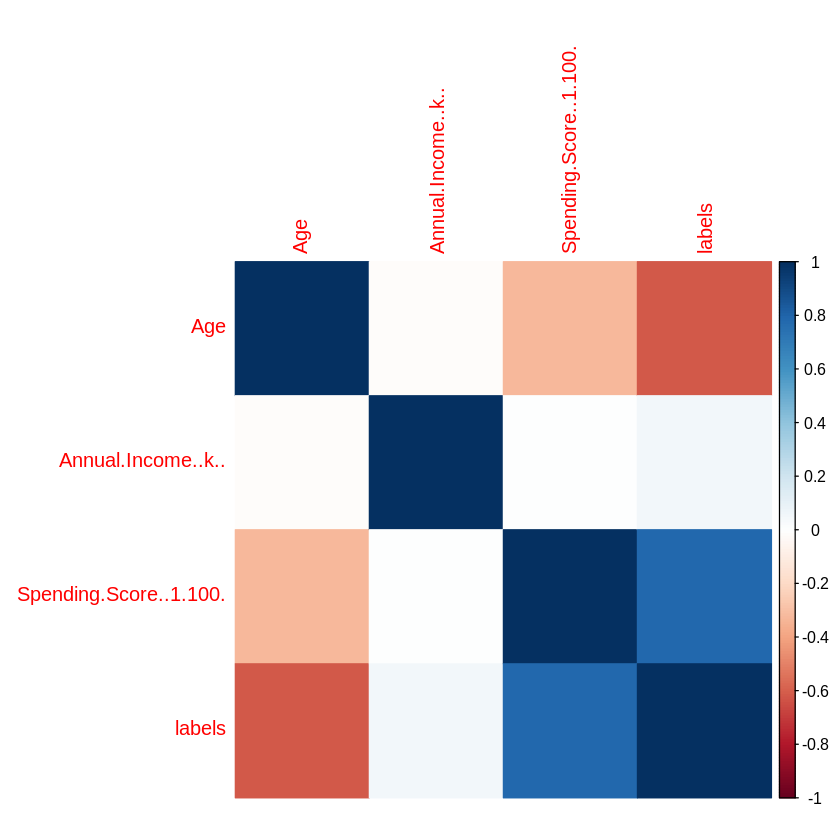

In [191]:
M = cor(shop_cust_df)
corrplot(M, method = 'color') # colorful number

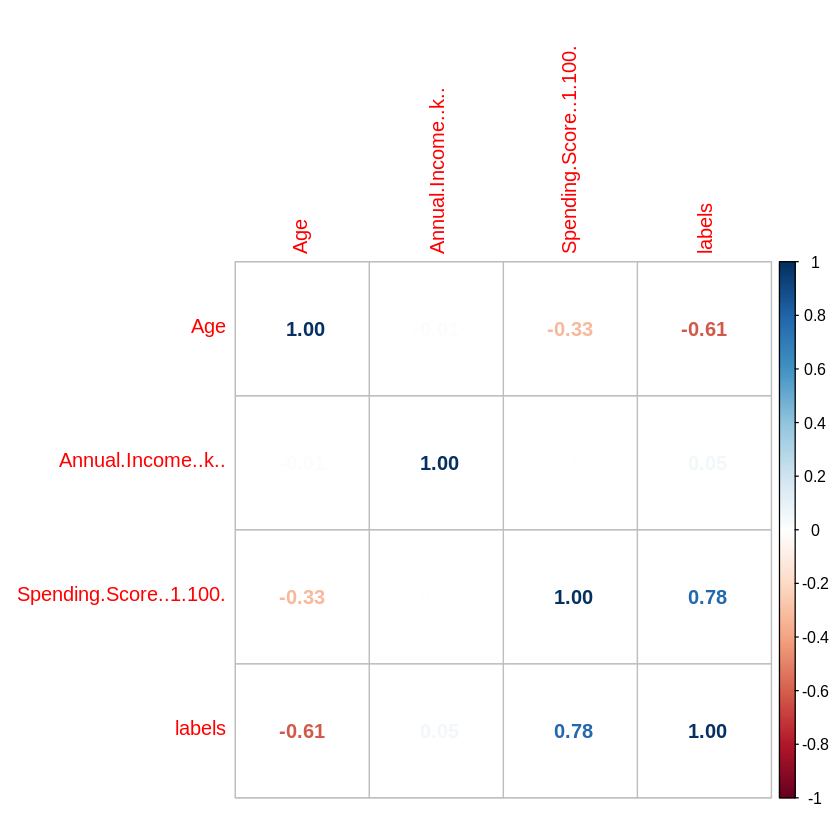

In [192]:
M = cor(shop_cust_df)
corrplot(M, method = 'number') # colorful number

In [193]:
#calculate correlation matrix
correlationMatrix <- cor(shop_cust_df)
# summarize the correlation matrix
print(correlationMatrix)

                               Age Annual.Income..k.. Spending.Score..1.100.
Age                     1.00000000       -0.012398043           -0.327226846
Annual.Income..k..     -0.01239804        1.000000000            0.009902848
Spending.Score..1.100. -0.32722685        0.009902848            1.000000000
labels                 -0.61064613        0.053044946            0.781782362
                            labels
Age                    -0.61064613
Annual.Income..k..      0.05304495
Spending.Score..1.100.  0.78178236
labels                  1.00000000


###  Apply the elbow method to determine the best k and plot.

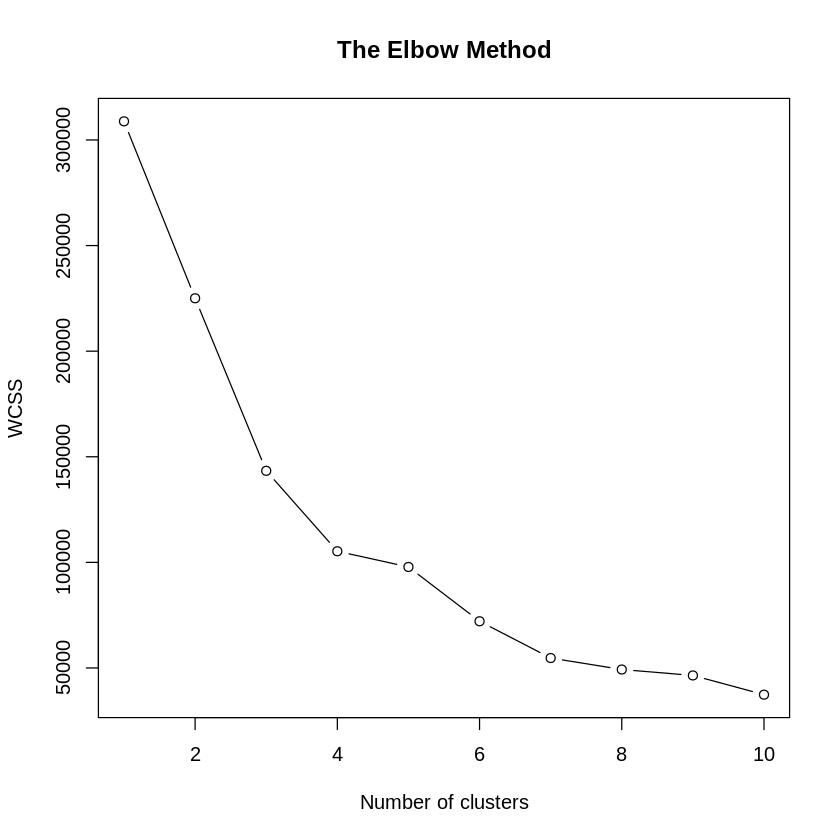

In [194]:
 #Using the elbow method to find the optimal number of clusters
set.seed(6)
wcss = vector()
for (i in 1:10) wcss[i] = sum(kmeans(Shopping_df, i)$withinss)
plot(1:10,
     wcss,
     type = 'b',
     main = paste('The Elbow Method'),
     xlab = 'Number of clusters',
     ylab = 'WCSS')

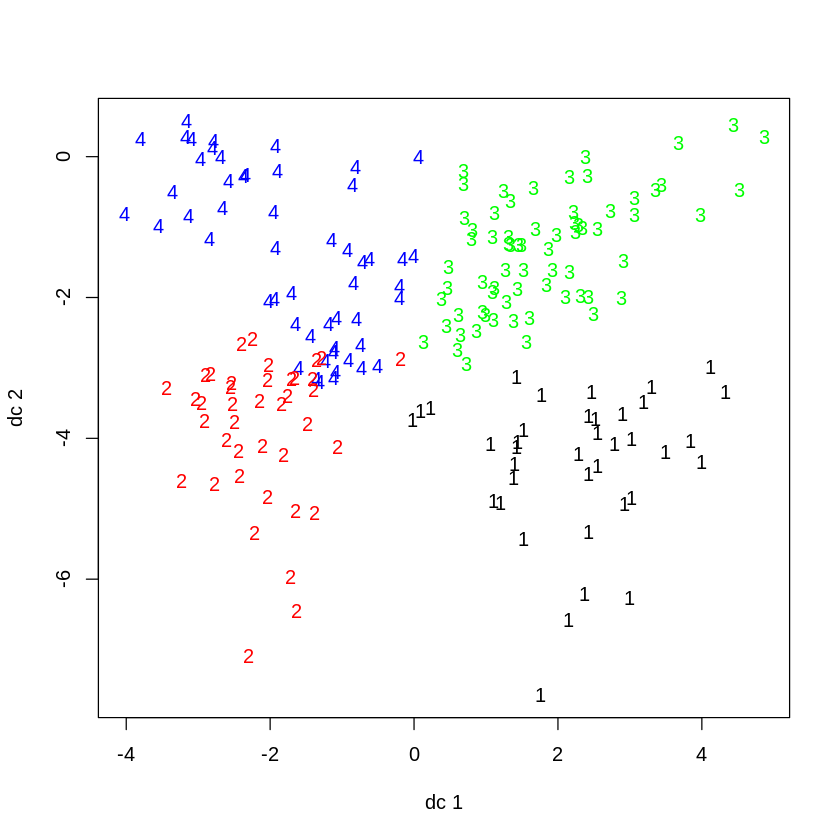

In [204]:
# Fitting K-Means to the Shopping_df dataset
set.seed(29)
clus = kmeans(x = Shopping_df, centers = 4)
y_kmeans = clus$cluster
plotcluster(Shopping_df, clus$cluster)

### 3 - Evaluate the quality of the clusters using the Silhouette Coefficient method. (10 points)


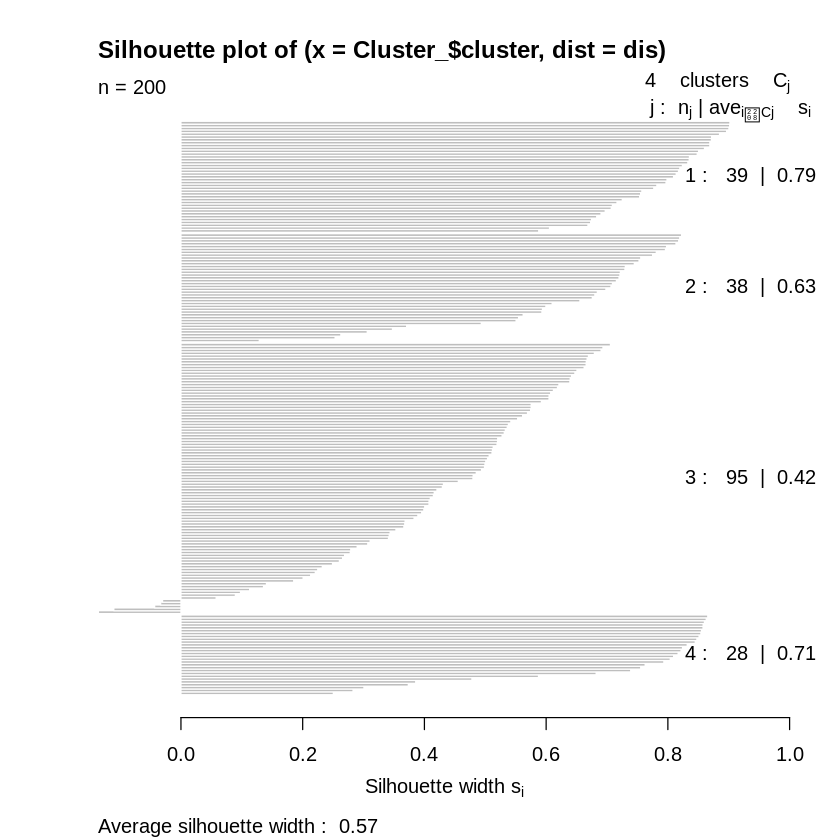

In [213]:
#install.packages('vegan')
library (vegan)
library (cluster)

dis = dist(Shopping_df)^2
Cluster_ = kmeans(Shopping_df,4)
sil = silhouette (Cluster_$cluster, dis)
# #windows() 
plot(sil)

# # Generate a k-means model using the pam() function with a k = 2
# pam_k2 <- pam(Shopping_df, k = 4 )

# # Plot the silhouette visual for the pam_k2 model
# plot(silhouette(pam_k2))


### 4-  Apply hierarchical clustering (single & complete linkage) to the dataset using Euclidean-based distance, and plot the dendrogram. Do your results depend on the type of linkage used? (10 points)

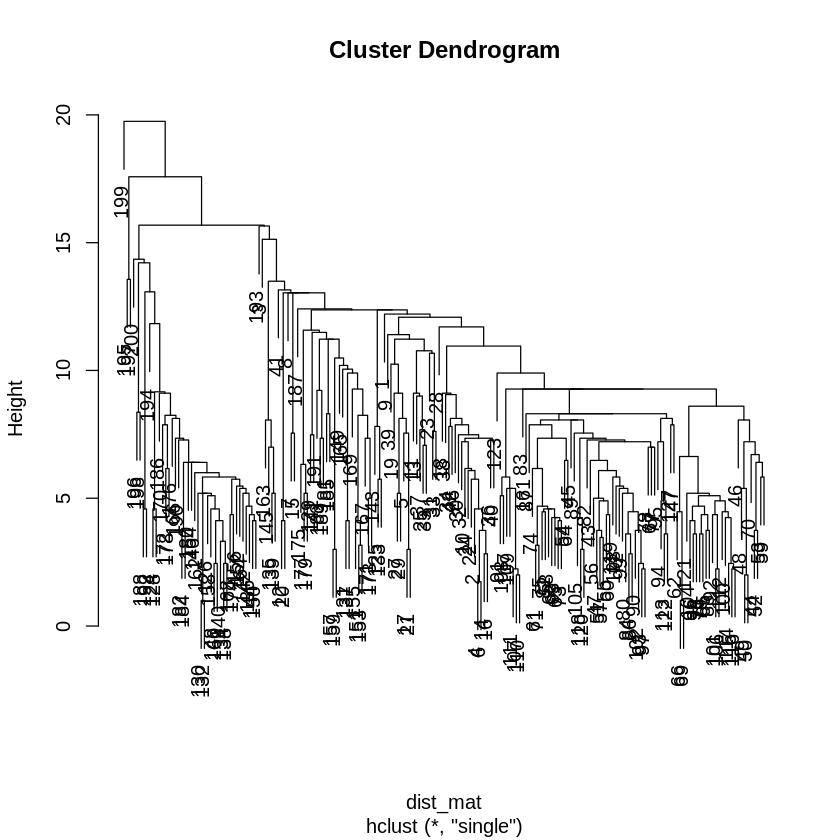

In [ ]:
# Single-linkage: calculates the minimum distance between the clusters before merging.
# This linkage may be used to detect high values in your dataset which may be outliers
# as they will be merged at the end.

dist_mat <- dist(Shopping_df, method = 'euclidean')
hclust_single <- hclust(dist_mat, method = 'single')
plot(hclust_single)

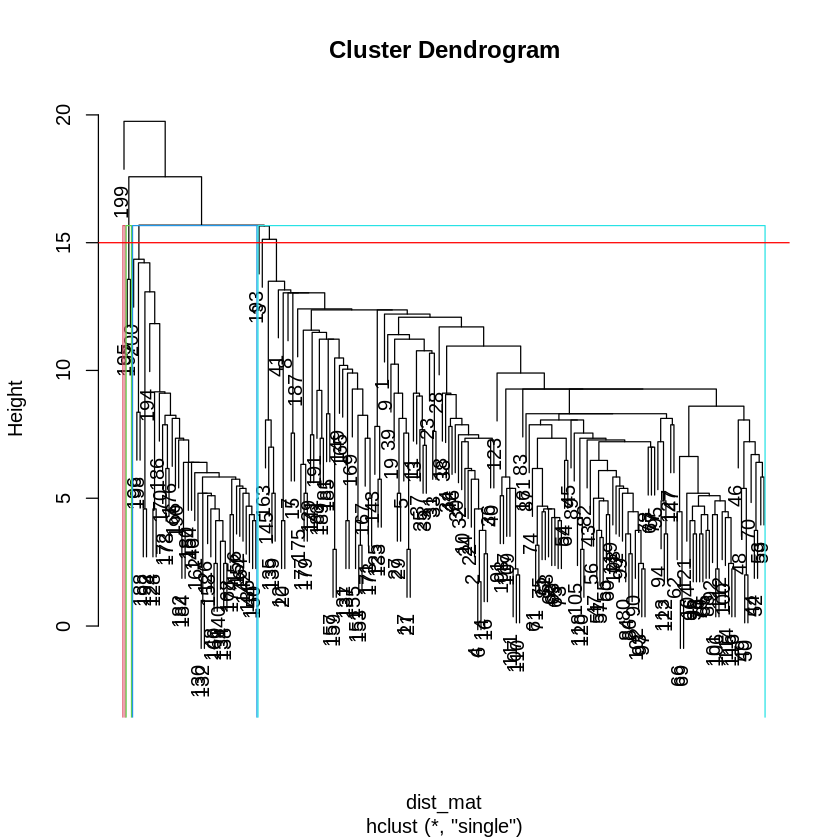

In [ ]:
cut_sg <- cutree(hclust_single, k = 4)
plot(hclust_single)
rect.hclust(hclust_single , k = 4, border = 2:6)
abline(h = 15, col = 'red')

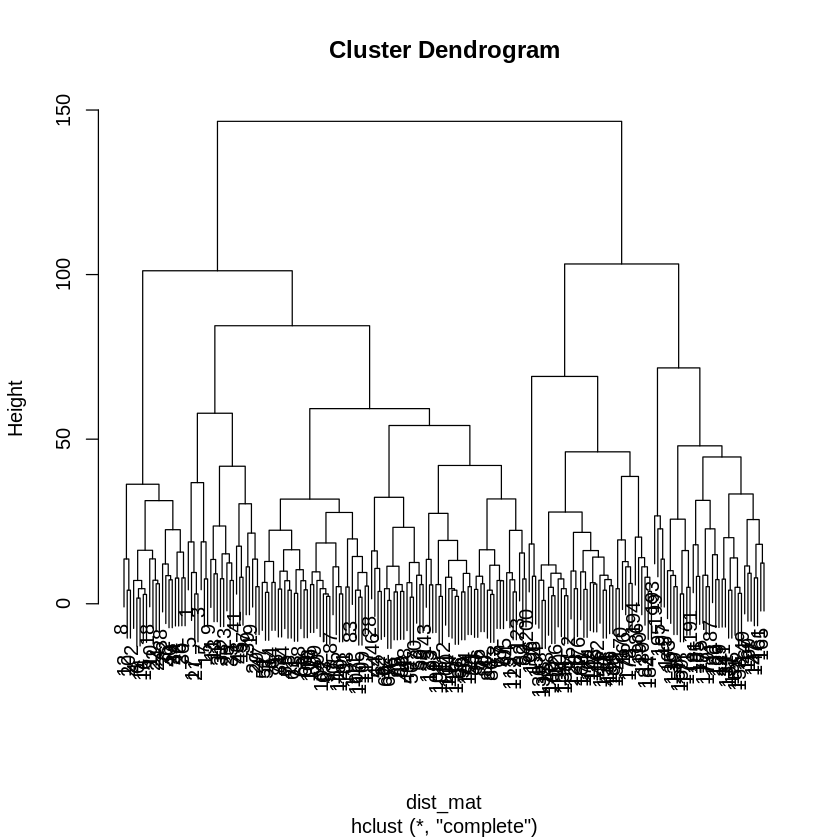

In [ ]:
#Complete-linkage: calculates the maximum distance between clusters
# before merging.

dist_mat <- dist(Shopping_df, method = 'euclidean')
hclust_com <- hclust(dist_mat, method = 'complete')
plot(hclust_com)

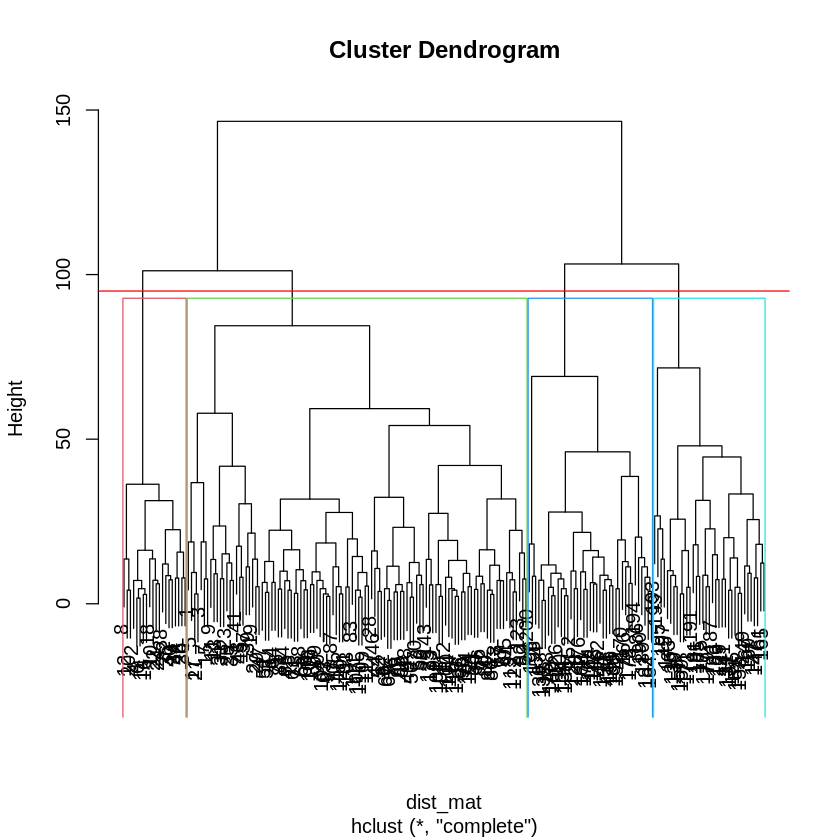

In [ ]:
cut_sg <- cutree(hclust_com, k = 4)
plot(hclust_com)
rect.hclust(hclust_com , k = 4, border = 2:6)
abline(h = 95, col = 'red')